# Base de dados _Super Image Resolution_

**O download da base de dados pode ser feito pelo *Kaggle*: [*Super Image Resolution*](https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution) (27,2MB)**

<sub>Para fazer o download da base de dados é necessário primeiramente fazer login no [*Kaggle*](https://www.kaggle.com/account/login?phase=startSignInTab&returnUrl=%2Fdatasets%2Fakhileshdkapse%2Fsuper-image-resolution).<br>O botão de download está localizado no canto superior direito do site.</sub>

---


A base de dados _Super Image Resolution_ foi construída para o problema de super resolução.
Ela é composta por dois grupos de imagens **RGB**: grupo de **baixa resolução (LR)** e grupo de **alta resolução (HR)**. No qual as **imagens do grupo LR possuem dimensão 4 vezes menor que as imagens do grupo HR**.
Para cada grupo suas imagens possuem a mesma resolução:


* LR: 96x96x3
* HR: 384x384x3

Ao descopactar a base de dados nota-se que os grupos estão separados por pastas (HR e LR). Onde cada amostra possui um número identificador, variando de 0 até 99. Logo, **existem 100 amostras ao todo**, o que representam 100 imagens do grupo LR e 100 imagens do grupo HR.

Abaixo está escrito um código que carrega o par de imagens da amostra de id 2, utilizando a biblioteca *matplotlib*. Além disso, algumas informações estão sendo mostradas, como: o tipo do dado carregado, os *shapes* e o valor mínimo e máximo das imagens carregadas. Utilizando esse método para carregar imagens, os valores estarão normalizados entre 0 e 1.

### Importando bibliotecas

In [115]:
!pip install tensorflow-gpu==2.6.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [116]:
from tensorflow.python.keras.layers import Add, BatchNormalization, Conv2D, Dense, Flatten, Input, LeakyReLU, PReLU, Lambda
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.applications.vgg19 import VGG19

# from model.common import pixel_shuffle, normalize_01, normalize_m11, denormalize_m11

import time
import tensorflow as tf

# from model import evaluate
# from model import srgan

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import Mean
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay


from tensorflow.python.data.experimental import AUTOTUNE

import os

import numpy as np
import matplotlib.pyplot as plt


from PIL import Image
%matplotlib inline

In [117]:
# !conda install -c conda-forge cudatoolkit=11.2 cudnn=8.1.0
# !export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/
# !python3 -m pip install tensorflow
# # Verify install:
# !python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

import tensorflow as tf
print(tf.version)
tf.config.list_physical_devices()
# com o notebook(ipynb) não reconhece a gpu mas pelo terminal sim

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

### Variaveis

In [118]:
LR_SIZE = 24
HR_SIZE = 96
DIV2K_RGB_MEAN = np.array([0.4488, 0.4371, 0.4040]) * 255

### Carregando dataset

In [119]:
# !unzip archive.zip

#### Normalizacões

In [120]:
def normalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return (x - rgb_mean) / 127.5

def denormalize(x, rgb_mean=DIV2K_RGB_MEAN):
    return x * 127.5 + rgb_mean

def normalize_01(x):
    """Normalizes RGB images to [0, 1]."""
    return x / 255.0

def normalize_m11(x):
    """Normalizes RGB images to [-1, 1]."""
    return x / 127.5 - 1

def denormalize_m11(x):
    """Inverse of normalize_m11."""
    return (x + 1) * 127.5

def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)
    

#### Metricas

In [121]:
def psnr(x1, x2):
    return tf.image.psnr(x1, x2, max_val=255)

#### Transformacões

In [122]:

def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))


def random_rotate(lr_img, hr_img):
    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lr_img, rn), tf.image.rot90(hr_img, rn)


In [123]:
def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]


def resolve(model, lr_batch):
    lr_batch = tf.cast(lr_batch, tf.float32)
    sr_batch = model(lr_batch)
    sr_batch = tf.clip_by_value(sr_batch, 0, 255)
    sr_batch = tf.round(sr_batch)
    sr_batch = tf.cast(sr_batch, tf.uint8)
    return sr_batch


def evaluate(model, dataset):
    psnr_values = []
    for lr, hr in dataset:
        sr = resolve(model, lr)
        psnr_value = psnr(hr, sr)[0]
        psnr_values.append(psnr_value)
    return tf.reduce_mean(psnr_values)

weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

#### Codigos auxiliares

In [124]:
def resolve_single(model, lr):
    return resolve(model, tf.expand_dims(lr, axis=0))[0]
    
def load_image(path):
    return np.array(Image.open(path))


def plot_sample(lr, sr):
    plt.figure(figsize=(20, 10))

    images = [lr, sr]
    titles = ['LR', f'SR (x{sr.shape[0] // lr.shape[0]})']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Tipo img_lr: <class 'numpy.ndarray'>
Shape LR image: (96, 96, 3)
Shape HR image: (384, 384, 3)
min(img_lr): 0.0 | max(img_lr): 0.92941177
min(img_hr): 0.0 | max(img_hr): 0.9372549 




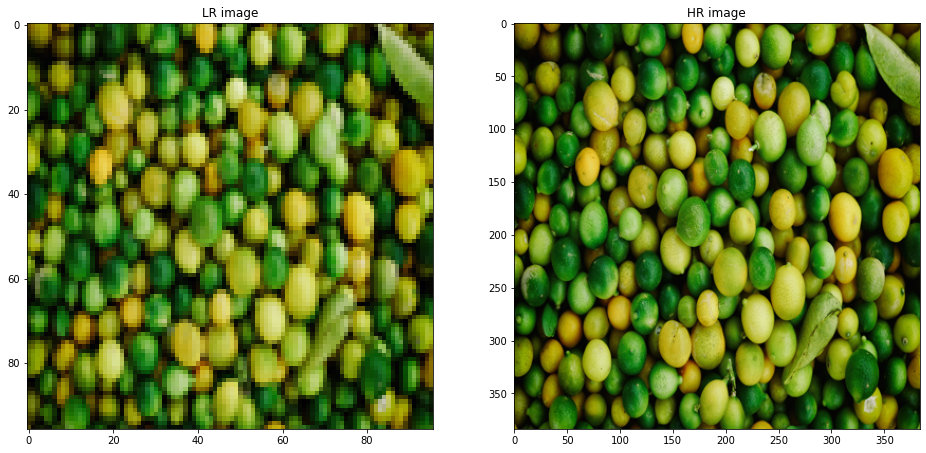

In [126]:
dir_lr = '/content/drive/MyDrive/PROJETO - VC3/Data/LR/1.png'
dir_hr = '/content/drive/MyDrive/PROJETO - VC3/Data/HR/1.png'

from matplotlib import pyplot as plt
from matplotlib import image

img_lr = image.imread(dir_lr)
img_hr = image.imread(dir_hr)

import numpy as np

print("Tipo img_lr:", type(img_lr))
print("Shape LR image:", img_lr.shape)
print("Shape HR image:", img_hr.shape)
print("min(img_lr):", np.min(img_lr), "| max(img_lr):", np.max(img_lr))
print("min(img_hr):", np.min(img_hr), "| max(img_hr):", np.max(img_hr), "\n\n")

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot('121').set_title('LR image')
imgplot = plt.imshow(img_lr, cmap='gray')
ax = fig.add_subplot('122').set_title('HR image')
imgplot = plt.imshow(img_hr, cmap='gray')
fig.show()

In [127]:
class DIV2K:
    def __init__(self,
                 scale=2,
                 subset='train',
                 downgrade='bicubic',
                 images_dir='.div2k/images',
                 caches_dir='.div2k/caches',
                 percent=0.5):

        self._ntire_2018 = True

        _scales = [2, 3, 4, 8]

        if scale in _scales:
            self.scale = scale
        else:
            raise ValueError(f'scale must be in ${_scales}')

        if subset == 'train':
            self.image_ids = range(1, int(100*percent))
        elif subset == 'valid':
            self.image_ids = range(int(100*percent), 100)
        else:
            raise ValueError("subset must be 'train' or 'valid'")

        self.subset = subset
        self.downgrade = downgrade
        self.images_dir = images_dir
        self.caches_dir = caches_dir

        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(caches_dir, exist_ok=True)

    def __len__(self):
        return len(self.image_ids)

    def dataset(self, batch_size=16, repeat_count=None, random_transform=True):
        ds = tf.data.Dataset.zip((self.lr_dataset(), self.hr_dataset()))
        
        if random_transform:
            ds = ds.map(lambda lr, hr: random_crop(lr, hr, scale=self.scale), num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
            ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
        ds = ds.batch(batch_size)
        ds = ds.repeat(repeat_count)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    def hr_dataset(self):
        if not os.path.exists(self._hr_images_dir()):
            raise ValueError("subset not found ")


        ds = self._images_dataset(self._hr_image_files()).cache(self._hr_cache_file())
        
        if not os.path.exists(self._hr_cache_index()):
            self._populate_cache(ds, self._hr_cache_file())

        return ds

    def lr_dataset(self):
        if not os.path.exists(self._lr_images_dir()):
            raise ValueError("subset not found ")
            
        ds = self._images_dataset(self._lr_image_files()).cache(self._lr_cache_file())
        
        if not os.path.exists(self._lr_cache_index()):
            self._populate_cache(ds, self._lr_cache_file())
        
        return ds

    def _hr_cache_file(self):
        return os.path.join(self.caches_dir, f'color_{self.subset}_HR.cache')

    def _lr_cache_file(self):
        return os.path.join(self.caches_dir, f'color_{self.subset}_LR_{self.downgrade}_X{self.scale}.cache')

    def _hr_cache_index(self):
        return f'{self._hr_cache_file()}.index'

    def _lr_cache_index(self):
        return f'{self._lr_cache_file()}.index'

    def _hr_image_files(self):
        images_dir = self._hr_images_dir()
        return [os.path.join(images_dir, f'{image_id}.png') for image_id in self.image_ids]

    def _lr_image_files(self):
        images_dir = self._lr_images_dir()
        return [os.path.join(images_dir, f'{image_id}.png') for image_id in self.image_ids]

    def _lr_image_file(self, image_id):
        return f'{image_id}.png'

    def _hr_images_dir(self):
        return os.path.join(self.images_dir, "LR")

    def _lr_images_dir(self):
        return os.path.join(self.images_dir, "LR")

    @staticmethod
    def _images_dataset(image_files):
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        ds = ds.map(tf.io.read_file)
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds

    @staticmethod
    def _populate_cache(ds, cache_file):
        print(f'Caching decoded images in {cache_file} ...')
        for _ in ds: pass
        print(f'Cached decoded images in {cache_file}.')


### Modelo SRCNN

In [128]:
SRCNN_915=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64,9,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(64,1,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,5,padding='same',activation='relu')
])

In [129]:
def pixel_mse_loss(y_true,y_pred):
  return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [130]:
SRCNN_915.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=pixel_mse_loss)

### Carrega o dataset

In [131]:
dir = "/content/drive/MyDrive/PROJETO - VC3"

os.makedirs(dir + "/caches", exist_ok=True)

data_loader_train = DIV2K(scale=4, 
                subset='train', 
                downgrade='bicubic', 
                images_dir= dir + "/Data",
                caches_dir= dir + "/caches",
                percent=0.7)
train = data_loader_train.dataset(4, random_transform=False)
data_loader_valid = DIV2K(scale=2, 
                subset='valid', 
                downgrade='bicubic', 
                images_dir= dir + "/Data",
                caches_dir= dir + "/caches",
                percent=0.3)
valid = data_loader_valid.dataset(4, random_transform=False, repeat_count=1)

### Treinador

In [132]:
class Trainer:
    def __init__(self,
                 model,
                 loss,
                 learning_rate,
                 checkpoint_dir='./ckpt/edsr'):

        self.now = None
        self.loss = loss
        self.checkpoint = tf.train.Checkpoint(step=tf.Variable(0),
                                              psnr=tf.Variable(-1.0),
                                              optimizer=Adam(learning_rate),
                                              model=model)
        self.checkpoint_manager = tf.train.CheckpointManager(checkpoint=self.checkpoint,
                                                             directory=checkpoint_dir,
                                                             max_to_keep=3)

        self.restore()

    @property
    def model(self):
        return self.checkpoint.model

    def train(self, train_dataset, valid_dataset, steps, evaluate_every=1000, save_best_only=False):
        loss_mean = Mean()

        ckpt_mgr = self.checkpoint_manager
        ckpt = self.checkpoint

        self.now = time.perf_counter()
        #print(steps, ckpt.step.numpy(), steps - ckpt.step.numpy())
        with open("loss_srcnn.csv", "a") as file:
            file.write(f'geral\n')

            for lr, hr in train_dataset.take(steps - ckpt.step.numpy()):
                
                ckpt.step.assign_add(1)
                step = ckpt.step.numpy()

                loss = self.train_step(lr, hr)
                loss_mean(loss)
                file.write(f'{loss_mean.result():.4f}\n')

                if step % evaluate_every == 0:
                    loss_value = loss_mean.result()
                    loss_mean.reset_states()

                    # Compute PSNR on validation dataset
                    psnr_value = self.evaluate(valid_dataset)

                    duration = time.perf_counter() - self.now
                    print(f'{step}/{steps}: loss = {loss_value.numpy():.3f}, PSNR = {psnr_value.numpy():3f} ({duration:.2f}s)')

                    if save_best_only and psnr_value <= ckpt.psnr:
                        self.now = time.perf_counter()
                        # skip saving checkpoint, no PSNR improvement
                        continue

                    ckpt.psnr = psnr_value
                    ckpt_mgr.save()

                    self.now = time.perf_counter()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.checkpoint.model(lr, training=True)
            loss_value = self.loss(hr, sr)

        gradients = tape.gradient(loss_value, self.checkpoint.model.trainable_variables)
        self.checkpoint.optimizer.apply_gradients(zip(gradients, self.checkpoint.model.trainable_variables))

        return loss_value

    def evaluate(self, dataset):
        return evaluate(self.checkpoint.model, dataset)

    def restore(self):
        if self.checkpoint_manager.latest_checkpoint:
            self.checkpoint.restore(self.checkpoint_manager.latest_checkpoint)
            print(f'Model restored from checkpoint at step {self.checkpoint.step.numpy()}.')
            
class SrganTrainer:
    #
    # TODO: model and optimizer checkpoints
    #
    def __init__(self,
                 generator,
                 discriminator,
                 content_loss='VGG54',
                 learning_rate=PiecewiseConstantDecay(boundaries=[100000], values=[1e-4, 1e-5])):

        if content_loss == 'VGG22':
            self.vgg = vgg_22()
        elif content_loss == 'VGG54':
            self.vgg = vgg_54()
        else:
            raise ValueError("content_loss must be either 'VGG22' or 'VGG54'")

        self.content_loss = content_loss
        self.generator = generator
        self.discriminator = discriminator
        self.generator_optimizer = Adam(learning_rate=learning_rate)
        self.discriminator_optimizer = Adam(learning_rate=learning_rate)

        self.binary_cross_entropy = BinaryCrossentropy(from_logits=False)
        self.mean_squared_error = MeanSquaredError()

    def train(self, train_dataset, steps=200000):
        pls_metric = Mean()
        dls_metric = Mean()
        step = 0

        for lr, hr in train_dataset.take(steps):
            step += 1

            pl, dl = self.train_step(lr, hr)
            pls_metric(pl)
            dls_metric(dl)

            if step % 50 == 0:
                print(f'{step}/{steps}, perceptual loss = {pls_metric.result():.4f}, discriminator loss = {dls_metric.result():.4f}')
                pls_metric.reset_states()
                dls_metric.reset_states()

    @tf.function
    def train_step(self, lr, hr):
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            lr = tf.cast(lr, tf.float32)
            hr = tf.cast(hr, tf.float32)

            sr = self.generator(lr, training=True)

            hr_output = self.discriminator(hr, training=True)
            sr_output = self.discriminator(sr, training=True)

            con_loss = self._content_loss(hr, sr)
            gen_loss = self._generator_loss(sr_output)
            perc_loss = con_loss + 0.001 * gen_loss
            disc_loss = self._discriminator_loss(hr_output, sr_output)

        gradients_of_generator = gen_tape.gradient(perc_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return perc_loss, disc_loss

    @tf.function
    def _content_loss(self, hr, sr):
        sr = preprocess_input(sr)
        hr = preprocess_input(hr)
        sr_features = self.vgg(sr) / 12.75
        hr_features = self.vgg(hr) / 12.75
        return self.mean_squared_error(hr_features, sr_features)

    def _generator_loss(self, sr_out):
        return self.binary_cross_entropy(tf.ones_like(sr_out), sr_out)

    def _discriminator_loss(self, hr_out, sr_out):
        hr_loss = self.binary_cross_entropy(tf.ones_like(hr_out), hr_out)
        sr_loss = self.binary_cross_entropy(tf.zeros_like(sr_out), sr_out)
        return hr_loss + sr_loss

class SRCNNTrainer(Trainer):
    def __init__(self,
                 model,
                 checkpoint_dir,
                 learning_rate=1e-4):
        super().__init__(model, loss=MeanSquaredError(), learning_rate=learning_rate, checkpoint_dir=checkpoint_dir)

    def train(self, train_dataset, valid_dataset, steps=1000000, evaluate_every=1000, save_best_only=True):
        super().train(train_dataset, valid_dataset, steps, evaluate_every, save_best_only)

In [133]:
# from model import resolve_single
# from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
   
    srcnn_sr = resolve_single(SRCNN_915, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, srcnn_sr]
    titles = ['LR', 'SRCNN']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [134]:

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    
    srcnn_sr = resolve_single(SRCNN_915, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, srcnn_sr]
    titles = ['LR', 'SRCNN']
    positions = [1, 2]
    print("LR", lr.shape, "SRCNN",srcnn_sr.shape)
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [139]:
pre_trainer = SRCNNTrainer(model= SRCNN_915, checkpoint_dir=f'.ckpt/pre_generator2')
pre_trainer.train(train,
                  valid.take(2),
                  steps=2000, 
                  evaluate_every=10, 
                  save_best_only=False)

10/2000: loss = 118.419, PSNR = 39.272484 (6.11s)
20/2000: loss = 33.767, PSNR = 35.177944 (5.47s)
30/2000: loss = 17.767, PSNR = 42.884308 (5.60s)
40/2000: loss = 9.172, PSNR = 40.512363 (5.35s)
50/2000: loss = 5.938, PSNR = 42.056599 (7.30s)
60/2000: loss = 5.590, PSNR = 43.686535 (5.19s)
70/2000: loss = 3.204, PSNR = 43.729866 (5.54s)
80/2000: loss = 4.507, PSNR = 44.032333 (5.28s)
90/2000: loss = 3.298, PSNR = 44.122147 (5.19s)
100/2000: loss = 3.751, PSNR = 44.098289 (5.67s)
110/2000: loss = 3.992, PSNR = 44.217087 (5.27s)
120/2000: loss = 3.133, PSNR = 44.235786 (5.64s)
130/2000: loss = 3.878, PSNR = 44.258926 (5.34s)
140/2000: loss = 3.195, PSNR = 44.277390 (5.73s)
150/2000: loss = 3.991, PSNR = 44.298401 (5.34s)
160/2000: loss = 2.732, PSNR = 44.309044 (7.31s)
170/2000: loss = 4.238, PSNR = 44.307728 (5.31s)
180/2000: loss = 3.176, PSNR = 44.301361 (5.46s)
190/2000: loss = 3.621, PSNR = 44.253162 (7.87s)
200/2000: loss = 3.920, PSNR = 44.307060 (5.17s)
210/2000: loss = 3.120, P

LR (384, 384, 3) SRCNN (384, 384, 3)


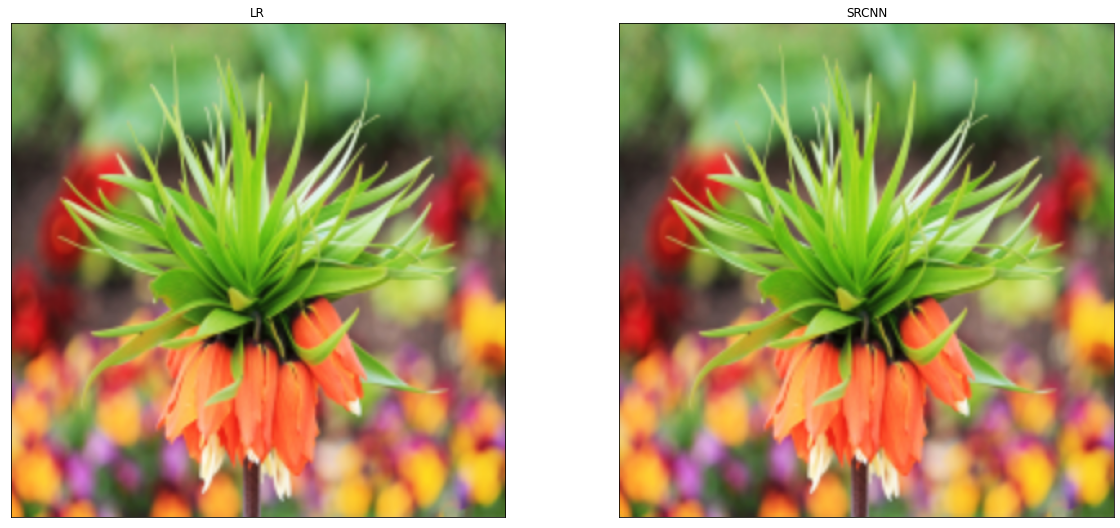

In [140]:
resolve_and_plot('/content/drive/MyDrive/PROJETO - VC3/resized/2.png')

In [141]:
import numpy as np
import pandas as pd

loss_srgan = pd.read_csv('loss_srcnn.csv', delimiter=";")
loss_srgan





,geral
0,8.3958
1,174.9345
2,147.7343
3,138.2845
4,143.5993
...,...
1995,2.0875
1996,2.0233
1997,2.6138
1998,3.0120


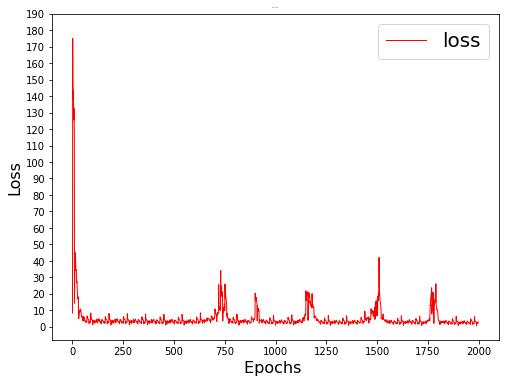

In [143]:
#Plot the loss curves
plt.figure(figsize=[8,6])
plt.plot(loss_srgan["geral"],'r',linewidth=1.0)
#plt.plot(loss_srgan[" gerador"],'b',linewidth=1.0)
#plt.plot(loss_srgan[" descriminador "],'g',linewidth=1.0)
plt.legend(['loss'],fontsize=20)
plt.xlabel('Epochs ',fontsize=16)
plt.yticks(np.arange (0, 200, 10))
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=1)
plt.show()
